Fine-tuned model

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [3]:
balanced_df=pd.read_csv("mel_labels_balanced_sorted.csv")

# Define class order
classes = list(balanced_df["instrument"].unique())
num_classes = len(classes)

print("Number of classes:", num_classes)
print("Class order:", classes)

# Convert single label → binary vector
def to_binary(label):
    vec = np.zeros(num_classes)
    vec[classes.index(label)] = 1
    return vec

balanced_df["binary_label"] = balanced_df["instrument"].apply(to_binary)

Number of classes: 14
Class order: ['Accordion', 'Alto Saxophone', 'Bass Tuba', 'Bassoon', 'Cello', 'Clarinet in Bb', 'Contrabass', 'Flute', 'French Horn', 'Oboe', 'Trombone', 'Trumpet in C', 'Viola', 'Violin']


In [4]:
print(balanced_df[["instrument", "binary_label"]].head())

  instrument                                       binary_label
0  Accordion  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1  Accordion  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2  Accordion  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3  Accordion  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4  Accordion  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [5]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df["instrument"],
    random_state=42
)

print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 7716
Validation samples: 1930


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [7]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="instrument",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="instrument",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 7716 validated image filenames belonging to 14 classes.
Found 1930 validated image filenames belonging to 14 classes.


In [35]:
num_classes = len(train_gen.class_indices)
model = models.Sequential([

    layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="sigmoid")
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = (224,224)
BATCH_SIZE = 32

def multilabel_generator(df, img_dir):
    while True:
        df = df.sample(frac=1)
        for i in range(0, len(df), BATCH_SIZE):
            batch = df.iloc[i:i+BATCH_SIZE]
            X, Y = [], []

            for _, row in batch.iterrows():
                img = load_img(img_dir + row["image"], target_size=IMG_SIZE)
                img = img_to_array(img) / 255.0
                X.append(img)
                Y.append(row["binary_label"])

            yield np.array(X), np.array(Y)


In [37]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    balanced_df, test_size=0.2, stratify=balanced_df["instrument"], random_state=42
)

train_gen = multilabel_generator(train_df, "mel_spectrograms/")
val_gen   = multilabel_generator(val_df, "mel_spectrograms/")

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df)//BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_df)//BATCH_SIZE,
    epochs=10
)


Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 99s 406ms/step - accuracy: 0.2726 - loss: 0.2656 - val_accuracy: 0.8505 - val_loss: 0.1079
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 107s 445ms/step - accuracy: 0.6327 - loss: 0.1498 - val_accuracy: 0.9635 - val_loss: 0.0488
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 901s 4s/step - accuracy: 0.7846 - loss: 0.1012 - val_accuracy: 0.9818 - val_loss: 0.0253
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 109s 453ms/step - accuracy: 0.8581 - loss: 0.0759 - val_accuracy: 0.9900 - val_loss: 0.0171
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 114s 474ms/step - accuracy: 0.8911 - loss: 0.0613 - val_accuracy: 0.9958 - val_loss: 0.0113
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 118s 489ms/step - accuracy: 0.9180 - loss: 0.0487 - val_accuracy: 0.9937 - val_loss: 0.0080
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 123s 508ms/step - accuracy: 0.9378 - loss: 0.0413 - val_accuracy: 0.9995 - val_loss: 0.0057
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 120s 496ms/step - accuracy: 0.9490 - los

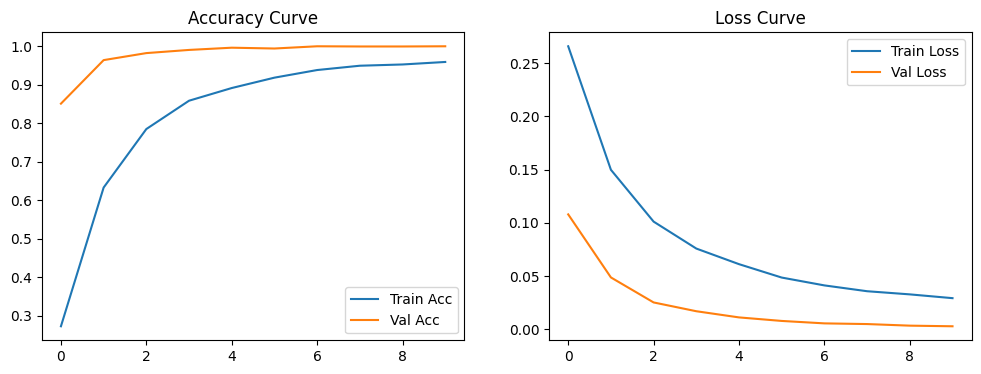

In [38]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.show()


In [39]:
train_acc = history.history["accuracy"][-1]
val_acc = history.history["val_accuracy"][-1]
train_loss = history.history["loss"][-1]
val_loss = history.history["val_loss"][-1]
print("Final Train Accuracy:", train_acc)
print("Final Val Accuracy:", val_acc)
print("Final Train Loss:", train_loss)
print("Final Val Loss:", val_loss)


Final Train Accuracy: 0.9587454199790955
Final Val Accuracy: 0.9994731545448303
Final Train Loss: 0.029363175854086876
Final Val Loss: 0.0029859477654099464


In [40]:
accuracy_gap = train_acc - val_acc
print("Accuracy Gap:", accuracy_gap)


Accuracy Gap: -0.04072773456573486


In [41]:
if accuracy_gap > 0.1:
    print("Model is likely overfitting")
else:
    print("Model generalizes well")


Model generalizes well


In [42]:
model.save("finetuned_cnn_model.h5")
print("Model saved successfully")


Model saved successfully


In [43]:
def predict_multilabel(image_path, threshold=0.5):
    img = load_img(image_path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    model=models.load_model("finetuned_cnn_model.h5")
    probs = model.predict(img)[0]
    binary = (probs >= threshold).astype(int)

    print("Probabilities:", probs)
    print("Predicted instruments:")

    for i, val in enumerate(binary):
        if val == 1:
            print(classes[i])



In [44]:
from sklearn.metrics import classification_report, f1_score, hamming_loss

# Collect validation predictions
y_true, y_pred = [], []

for _ in range(len(val_df)//BATCH_SIZE):
    X, Y = next(val_gen)
    preds = model.predict(X)
    y_true.extend(Y)
    y_pred.extend((preds >= 0.5).astype(int))

print("Macro F1:", f1_score(y_true, y_pred, average="macro"))
print("Hamming Loss:", hamming_loss(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━

In [9]:
# Evaluate on test data
model=models.load_model("finetuned_cnn_model.h5")
test_loss, test_accuracy = model.evaluate(val_gen)

print("Final Test Accuracy:", test_accuracy)
print("Final Test Loss:", test_loss)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9995 - loss: 0.0031
Final Test Accuracy: 0.9994818568229675
Final Test Loss: 0.0030899939592927694


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step


<Figure size 1000x1000 with 0 Axes>

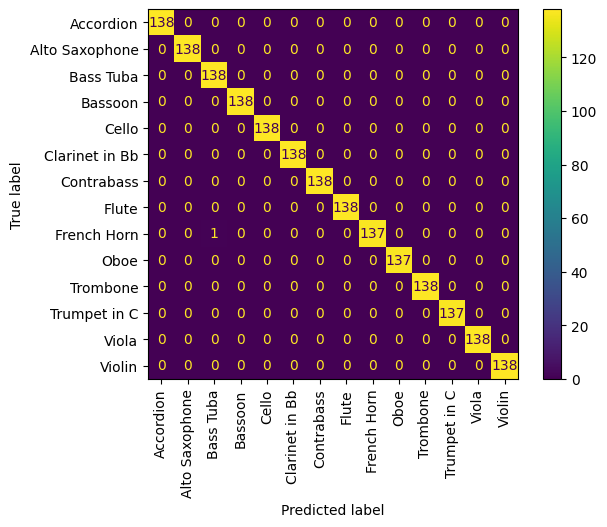

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step
                precision    recall  f1-score   support

     Accordion       1.00      1.00      1.00       138
Alto Saxophone       1.00      1.00      1.00       138
     Bass Tuba       0.99      1.00      1.00       138
       Bassoon       1.00      1.00      1.00       138
         Cello       1.00      1.00      1.00       138
Clarinet in Bb       1.00      1.00      1.00       138
    Contrabass       1.00      1.00      1.00       138
         Flute       1.00      1.00      1.00       138
   French Horn       1.00      0.99      1.00       138
          Oboe       1.00      1.00      1.00       137
      Trombone       1.00      1.00      1.00       138
  Trumpet in C       1.00      1.00      1.00       137
         Viola       1.00      1.00      1.00       138
        Violin       1.00      1.00      1.00       138

      accuracy                           1.00      1930
     macro avg       1.00      1.00      1.00      1930
  wei

In [10]:
import numpy as np
from sklearn.metrics import classification_report
# True labels
y_true = val_gen.classes

# Predictions
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(val_gen.class_indices.keys())
)

plt.figure(figsize=(10,10))
disp.plot(xticks_rotation=90)
plt.show()
# True labels
y_true = val_gen.classes

# Predictions
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class-wise report
report = classification_report(
    y_true,
    y_pred,
    target_names=list(val_gen.class_indices.keys())
)

print(report)
